In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,StratifiedKFold,GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import roc_auc_score,roc_curve

In [29]:
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = [12,4]
sns.set_style('whitegrid')

In [127]:
X_synthetic, y_synthetic = make_classification(n_samples=1000,n_features=200,
                                               n_informative=3,n_classes=2,n_redundant=0,
                                               class_sep=0.8,random_state=24)

In [128]:
print(X_synthetic.shape,y_synthetic.shape)

(1000, 200) (1000,)


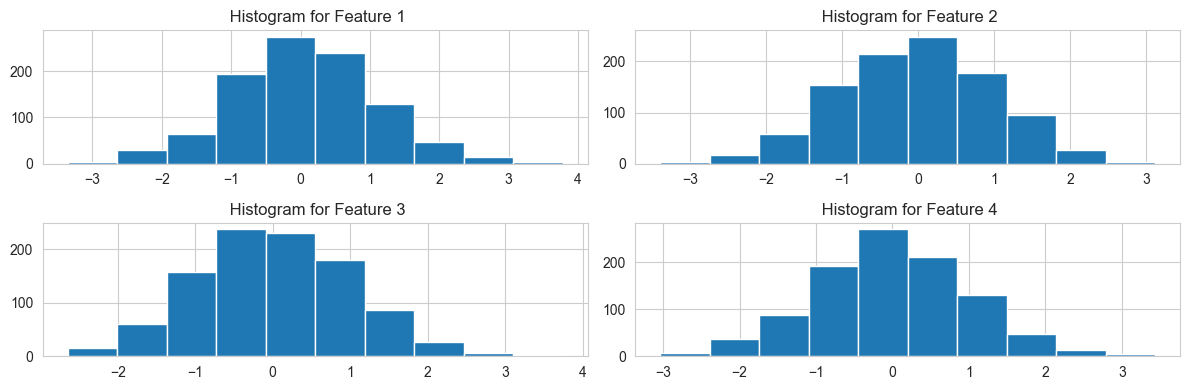

In [129]:
for plot_index in np.arange(4):
    plt.subplot(2,2,plot_index+1)
    plt.hist(X_synthetic[:,plot_index])
    plt.title(f' Histogram for Feature {plot_index+1}')
plt.tight_layout()

In [130]:
X_train,X_test,y_train,y_test = train_test_split(X_synthetic,y_synthetic,test_size=0.2,random_state=42)

In [131]:
lr_syn = LogisticRegression()
lr_syn.solver = 'liblinear'
lr_syn.penalty = 'l1'
lr_syn.C = 1000

In [132]:
lr_syn.fit(X_train,y_train)

LogisticRegression(C=1000, penalty='l1', solver='liblinear')

In [133]:
y_syn_pred = lr_syn.predict(X_train)
roc_auc_score(y_train,y_syn_pred)

0.8801125703564727

In [134]:
# lr_syn.predict(X_train)

In [135]:
y_syn_pred_test = lr_syn.predict(X_test)
roc_auc_score(y_test,y_syn_pred_test)

0.6663474140538361

In [136]:
c_vals = (10.0)**(-1*np.arange(-3,3,0.5))

In [137]:
np.empty((4,12)).shape

(4, 12)

In [138]:
def cross_val_C_search(k_folds:'K_fold model',C_vals:'list of c values',model:'model',X,Y):
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds,len(C_vals)))
    cv_test_roc_auc  = np.empty((n_folds,len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)

    for c_val_counter in range(len(C_vals)):
        # Set the C value for the model objects
        model.C = C_vals[c_val_counter]
        model.max_iter = 1000
        # Count folds for each value of c
        fold_counter = 0
        for train_index, test_index in k_folds.split(X,Y):
            X_cv_train, X_cv_test = X[train_index],X[test_index]
            y_cv_train, y_cv_test = Y[train_index],Y[test_index]
            model.fit(X_cv_train,y_cv_train)

            # calculate train reciever oparating curve - area under the curve
            y_cv_train_predict = model.predict(X_cv_train)
            cv_train_roc_auc[fold_counter,c_val_counter] = roc_auc_score(y_cv_train,y_cv_train_predict)

            # calculate test reciever operating curve - area under the curve
            y_cv_test_predict = model.predict(X_cv_test)
            cv_test_roc_auc[fold_counter,c_val_counter] = roc_auc_score(y_cv_test,y_cv_test_predict)

            this_fold_roc = roc_curve(y_cv_test,y_cv_test_predict)
            cv_test_roc[c_val_counter].append(this_fold_roc)

            fold_counter += 1
        print(f"Done with C = {model.C:0.2f}")

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [139]:
n_folds = 4
k_folds =  KFold(n_splits=4,shuffle = False)

In [140]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search(k_folds,c_vals,lr_syn,X_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Done with C = 1000.00


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Done with C = 316.23


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Done with C = 100.00
Done with C = 31.62
Done with C = 10.00
Done with C = 3.16
Done with C = 1.00
Done with C = 0.32
Done with C = 0.10
Done with C = 0.03
Done with C = 0.01
Done with C = 0.00


In [141]:
pd.DataFrame(cv_train_roc_auc,columns=c_vals)

,1000.000000,316.227766,100.000000,31.622777,10.000000,3.162278,1.000000,0.316228,0.100000,0.031623,0.010000,0.003162
0,1.000000,1.000000,1.000000,1.000000,0.996655,0.956510,0.935066,0.897498,0.839857,0.817008,0.808745,0.5
1,0.975021,0.975021,0.975021,0.951848,0.936760,0.921784,0.908558,0.883468,0.843568,0.818755,0.818755,0.5
2,1.000000,1.000000,1.000000,1.000000,1.000000,0.973462,0.936655,0.898426,0.846906,0.806855,0.806855,0.5
3,1.000000,1.000000,1.000000,1.000000,0.971747,0.949995,0.926726,0.890189,0.831967,0.800113,0.801764,0.5


In [142]:
pd.DataFrame(cv_test_roc_auc,columns=c_vals)

,1000.000000,316.227766,100.000000,31.622777,10.000000,3.162278,1.000000,0.316228,0.100000,0.031623,0.010000,0.003162
0,0.716586,0.716586,0.721216,0.721216,0.722021,0.717391,0.753019,0.765298,0.775362,0.791667,0.807166,0.5
1,0.711278,0.711278,0.711278,0.721805,0.721303,0.731328,0.721805,0.764160,0.798496,0.778947,0.778947,0.5
2,0.704235,0.709554,0.699518,0.704235,0.704235,0.708350,0.749699,0.730831,0.781012,0.815837,0.815837,0.5
3,0.736609,0.741282,0.741282,0.741282,0.737313,0.742689,0.777510,0.760225,0.811175,0.836650,0.831977,0.5


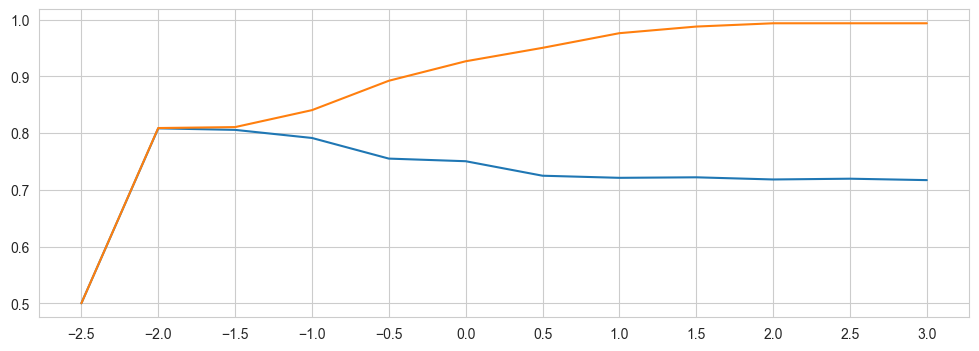

In [143]:
plt.plot(np.log10(c_vals),cv_test_roc_auc.mean(axis=0))
plt.plot(np.log10(c_vals),cv_train_roc_auc.mean(axis=0))
plt.xticks(np.log10(c_vals))
plt.show()

In [144]:
10**-1.5

0.03162277660168379

In [200]:
lr_syn = LogisticRegression(max_iter=1000)
params = {'C':c_vals,'penalty':['l1'],'solver' : ['liblinear']}

clf = GridSearchCV(estimator=lr_syn,param_grid=params,cv=4,verbose=2,scoring='roc_auc')
clf.fit(X_train,y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV] END .............C=1000.0, penalty=l1, solver=liblinear; total time=   1.4s
[CV] END .............C=1000.0, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .............C=1000.0, penalty=l1, solver=liblinear; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .............C=1000.0, penalty=l1, solver=liblinear; total time= 2.9min
[CV] END .C=316.22776601683796, penalty=l1, solver=liblinear; total time=   1.7s
[CV] END .C=316.22776601683796, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .C=316.22776601683796, penalty=l1, solver=liblinear; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .C=316.22776601683796, penalty=l1, solver=liblinear; total time= 2.7min
[CV] END ..............C=100.0, penalty=l1, solver=liblinear; total time=   1.3s
[CV] END ..............C=100.0, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ..............C=100.0, penalty=l1, solver=liblinear; total time=   0.8s
[CV] END ..............C=100.0, penalty=l1, solver=liblinear; total time=   2.5s
[CV] END .C=31.622776601683793, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END .C=31.622776601683793, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .C=31.622776601683793, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END .C=31.622776601683793, penalty=l1, solver=liblinear; total time=   2.5s
[CV] END ...............C=10.0, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ...............C=10.0, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ...............C=10.0, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ...............C=10

GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': array([1000.        ,  316.22776602,  100.        ,   31.6227766 ,
         10.        ,    3.16227766,    1.        ,    0.31622777,
          0.1       ,    0.03162278,    0.01      ,    0.00316228]),
                         'penalty': ['l1'], 'solver': ['liblinear']},
             scoring='roc_auc', verbose=2)

In [192]:
# import sklearn
# sklearn.metrics.get_scorer_names()

In [194]:
clf.best_params_


{'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}

In [195]:
clf.best_estimator_

LogisticRegression(C=1000.0, max_iter=1000, penalty='l1', solver='liblinear')

In [196]:
clf.cv_results_

{'mean_fit_time': array([39.845855  ,  0.0001871 , 36.76778275,  0.0001812 ,  1.15155691,
         0.00020623,  1.11793303,  0.0001893 ,  0.61146915,  0.00019902,
         0.11955971,  0.00015956,  0.03598505,  0.00035441,  0.01484454,
         0.00017452,  0.00504071,  0.00015205,  0.00338894,  0.00013709,
         0.00288898,  0.0001362 ,  0.00217766,  0.00013846]),
 'std_fit_time': array([67.56650042,  0.00008108, 62.23873983,  0.0000732 ,  0.78773618,
         0.00010953,  0.76677314,  0.00009508,  0.34181724,  0.00010387,
         0.05361753,  0.00004475,  0.00884165,  0.00014701,  0.00082417,
         0.00004402,  0.00044479,  0.00002514,  0.00018425,  0.00002459,
         0.00003064,  0.00002346,  0.00005058,  0.0000188 ]),
 'mean_score_time': array([0.0030452 , 0.        , 0.00154173, 0.        , 0.0013144 ,
        0.        , 0.00136542, 0.        , 0.00129068, 0.        ,
        0.00128311, 0.        , 0.00192004, 0.        , 0.00176597,
        0.        , 0.00110674, 0.  

In [160]:
# X_scaled =  minmax_scale(X_train)

In [161]:
# X_scaled

array([[0.90254712, 0.89450918, 0.27746758, ..., 0.438506  , 0.43723935,
        0.30148653],
       [0.43834064, 0.48154813, 0.59072254, ..., 0.37960781, 0.68604399,
        0.39042068],
       [0.76903342, 0.52339775, 0.56465267, ..., 0.43297566, 0.60525115,
        0.22557637],
       ...,
       [0.5487086 , 0.32943404, 0.54487036, ..., 0.59070313, 0.58981451,
        0.24938455],
       [0.47438173, 0.46926199, 0.46773263, ..., 0.36258373, 0.4319974 ,
        0.43118893],
       [0.52940172, 0.75241901, 0.25539789, ..., 0.63269086, 0.34168843,
        0.42134855]])

In [198]:
# X_scal =  minmax_scale(X_test)
y_pred = clf.predict(X_test)
roc_auc_score(y_test,y_pred)

0.6663474140538361

In [199]:
y_train_pred = clf.predict(X_train)
roc_auc_score(y_train,y_train_pred)

0.8801125703564727